In [1]:
import numpy as np

# from methods.base import BaseConfig

# from methods.plotting import plot_perm, plot_press_plan, plot_event_list, plot_ev_dens_slice
# from methods.pore_press_calc_functions import Diffusion_with_Source_and_Gravity, test_wells, get_q_factors

In [29]:
a = 123.232//10
type(a)

float

In [ ]:
''' from base py'''
import numpy as np
from scipy.interpolate import make_interp_spline
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

class FlowConfig:
    def __init__(self, **kwargs):
        # model params
        self.sides = ((0, 4000), (0, 500), (0, 4000)) # meters, y - vertical ax, upward directed
        self.shape = (160, 20, 160)   
        self.depth = 1500 # depth of the upper bound

        # time params 
        self.t_range = 3600*24*1000 # time range for calculation in sec
        self.timestep = int(self.t_range // 1000) # time step in sec for saving
            
        # sources
        self.sources = [
            {'loc':(2000, 250, 2000), 'Q': self.get_q_interp(q = 0.016),  'P': 2.5}, # P - target overpressue inplace, MPa 
                        ]

        # media params:
        # fluid
        self.nu = 1 # visc cP
        self.ro = 1000 # fluid dencity, kg/m3
        self.K_ro = 10**4 # MPa  dP = K_ro * (dro/ro0)  fluid compressabitity

        # solid
        self.m = 0.2 # porocity
        self.k = 0.2 # permeability, Darcy
        self.K_m = 10**4 # MPa  dP = K_m * (dm/m0) pore space compressabitity

        self.__dict__.update(kwargs) # updating while init
        
    def get_q_interp(self, q):
        '''volume rate time dependence here'''
        q = np.array([q, q])
        t = np.array([0, self.t_range])
        return make_interp_spline(t, q, k=1) 

    def update(self, **kwargs):
        self.__dict__.update(kwargs)
  
    def dump(self, filename='params.yaml'):
        with open(filename, 'w') as f:
            yaml.dump(self.__dict__, f, Dumper=Dumper)

    def load(self, filename='params.yaml'):
        try:
            with open(filename, 'r') as f:
                new_params_dict = yaml.load(f, Loader=Loader)
                self.__dict__.update(**new_params_dict)
        except:
            raise FileNotFoundError('Cant find such params file')
        
    def __repr__(self) -> str:
        return str(self.__dict__)

In [37]:
'''from pore press calc func'''
import numpy as np
# import h5py
from tqdm.notebook import tqdm
# from scipy.interpolate import make_interp_spline
from pde import PDEBase, ScalarField, VectorField, MemoryStorage, CartesianGrid
from pde.tools.numba import jit

class Diffusion_with_Source_and_Gravity(PDEBase):
    """Diffusion equation with spatial dependence"""
    def __init__(self, params):
        super().__init__()

        '''models geometry'''
        self.shape = params.shape # points
        self.sides = params.sides # meters
        self.depth = params.depth # meters depth of the upper bound

        # generate grid
        self.grid = CartesianGrid(self.sides, self.shape)
    
        # time
        self.t_range = params.t_range # запихал это сюда, чтобы все было в одном месте, 
        self.timestep = params.timestep  # чтобы было удобно сохранить весь обьект и не морочиьтся со всякими ямлами 

        '''consts'''
        self.P0 = 0.101 # начальное давление на поверхности - атмосфера
        self.g = 9.81 # gravity

        # fluid
        self.nu = params.nu # visc cP
        self.ro = params.ro # fluid dencity, kg/m3
        self.K_ro = params.K_ro # MPa  dP = K_ro * (dro/ro0)  fluid compressabitity

        # solid
        self.m = params.m # porocity
        self.k = params.k # permeability, Darcy
        self.K_m = params.K_m # MPa  dP = K_m * (dm/m0) pore space compressabitity

        self.source_locs = [s['loc'] for s in params.sources]  # list of source locations
        self.source_time_interpolators = [s['Q'] for s in params.sources] # list of source time funcs
        self.q_factors = np.ones(len(self.source_locs))

        # boundary condition
        self.bc = {"derivative": 0} # Neumann

        # diffusion coefficient scalar field
        self.xi_field = self.update_xi_field()

        # initial pore pressure
        self.p_ini_field = ScalarField(self.grid, data=self.get_ro_g_h()) # MPa

        # initial zero source field
        self.source_field = self.update_source_field(0) # spatial source field, initial state
        
    def update_xi_field(self, k=None):
        '''
        perm - permeability np.array 
    
        Function for calculating the diffusion coefficient. Details - Barenblatt p. 19
        Dimensionality:
        1 MPa = 10^7 g/cm*s^2
        1 D = 10^-8 cm^2
        1 cP = 10^-2 g/cm*s
        Therefore, the dimensionality of [xi] is:
        [xi] = [D] * [MPa] / [cP] =
            = 10^-8 [cm^2] * 10^7 [g/cms^2] / 10^-2 [g/cms] =
            = 10^1 [cm^2/s] =
            = 10^-3 [m^2/s]

        returns numpy array with distributed xi value    
        '''
        if k is not None:
            self.k = k
        xi = 10**-3 * self.k / (self.m * self.nu * (1/self.K_ro + 1/self.K_m)) # m^2/s
        return ScalarField(self.grid, data=xi)  
   
    
    def dPdt_Q(self, Q):
        '''
        arg  - some float value of Q = dv/dt
        dP/dt ~ K_m * ((dv/dt)/V) - pressure change when dv of fluid is pumped in volume V
        returns float source value, rescaled to time scale
        '''
        # V = self.depth * 3.1415 * 0.1**2 / 4  # some kind of "volume" of source (borehole). m^3
        # dPdt = self.K_ro * Q / V # pressure change MPa/s
        dPdt = self.K_ro * Q # point source
        return dPdt  
      
    def update_source_field(self, t):
        '''
        assembling source points and applying specific rates. Iterates over source locations. q coefficients for correcting overpressure at source locations
        '''
        source_field = ScalarField(self.grid, data=0) # spatial source field
        for ii, loc in enumerate(self.source_locs):
            q = self.q_factors[ii] * self.source_time_interpolators[ii](t) #.item()
            dpdt = self.dPdt_Q(q)
            source_field.insert(loc , dpdt)  #  one borehole == point source at params.source_loc location

        return source_field
    
    def get_ro_g_h(self):
        p_upper = self.ro * self.g * 1e-6 * self.depth * np.ones(self.shape) # pressure on the upper bound, 1e-6 - to be good with pressire in MPa
        ro_g = self.ro * self.g * 1e-6 * self.grid.cell_volume_data[1] * np.ones(self.shape)
        ro_g_h = np.cumsum(ro_g, axis=1) - ro_g/2  # hydrostatic field, in the middle of a cell
        ro_g_h = np.flip(ro_g_h, axis=1) # Y directed upward
        return p_upper + ro_g_h
        
        
    def evolution_rate(self, state, t=0):
        ''' all magic here '''
        # self.source_field = self.update_source_field(t) # updating source field. implicit source time dependence here
        Pf = state - self.p_ini_field # == hydrostatic field
        lapace_Pf = Pf.laplace(bc=self.bc)
        dP_dt = self.xi_field * lapace_Pf + self.source_field 
        return dP_dt

In [59]:
params = FlowConfig()

eq = Diffusion_with_Source_and_Gravity(params)

p0 = eq.p_ini_field

storage = MemoryStorage()

res = eq.solve(p0, t_range=eq.t_range, adaptive=True, tracker=['progress', 'plot', storage.tracker(eq.timestep)])

  0%|          | 0/86400000.0 [00:00<?, ?it/s]

Output()

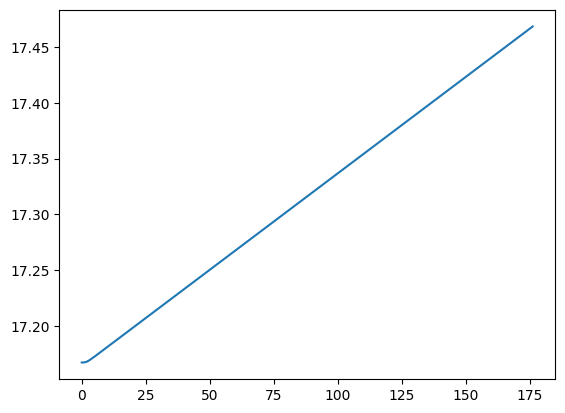

In [41]:
pp = np.array(storage.data)
plt.plot(pp[:,5,10,5])

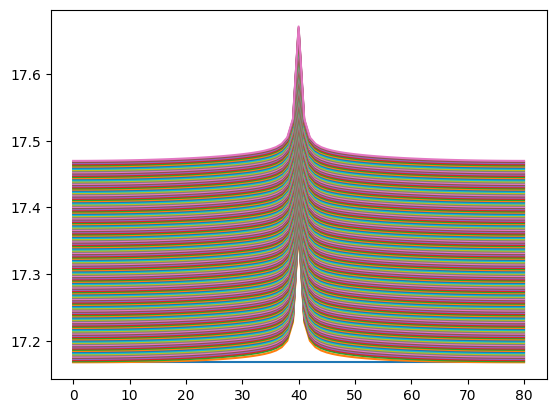

In [47]:
for p in pp:
    plt.plot(p[:,10,40])

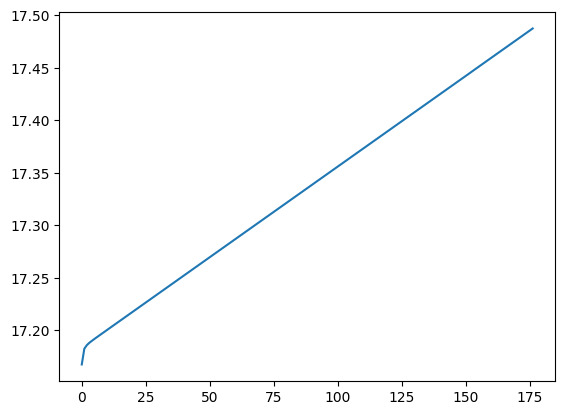

In [49]:
pp = np.array(storage.data)
plt.plot(pp[:,35,10,40])